In [1]:
import os
import json
import collections
import random

from bs4 import BeautifulSoup
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

In [21]:
base_path = os.getcwd() + '/dataset/train/'

damageTypes=["None", "D00", "D10", "D20", "D40", "D01", "D11",  "D43", "D44", "D50", "D0w0"]

#{D00: Longitudinal Crack, D10: Transverse Crack, D20: Aligator Crack, D40: Pothole}

# govs.
govs = ["Czech", "India", "Japan"]

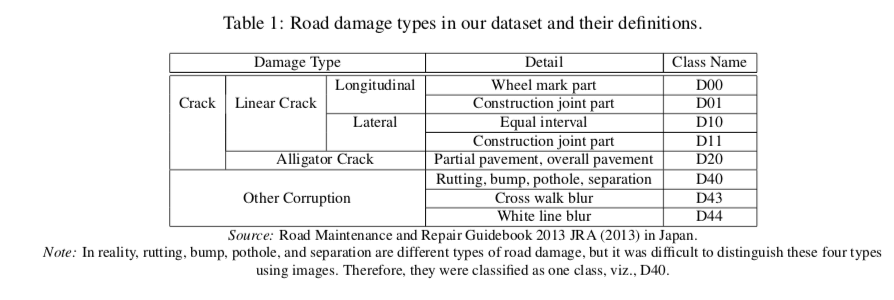

## JSON file creation for test1

In [8]:
images = []

def format_as_json():
    annotations = open("dataset/annotation.txt", "r")
    for data in annotations:
        line = data.strip().split(',')
        key = line[0]
        if(line[1]==''):
            line[1] = '0'
        obj = line[1].split()
        image = {
            key: [
                {
                    'class': obj[0],
                    'location': ' '.join(map(str, obj[1:5])),
                }
            ]
        }

        index=5
        while(len(obj[index:])!=0):
            image[key].append({
                'class': obj[index],
                'location': ' '.join(map(str, obj[index+1:index+5])),
            })
            index=index+5

        images.append(image)

    annotations.close()

def save_as_json():
    with open('dataset/test_data.json', 'w') as fp:
        json.dump(images, fp)

format_as_json()
save_as_json()

## DataFrame file creation for test1

In [11]:
def dataframe_creation():
    keys = []
    classes = []
    objects = []
    damages = []
    countries = []
    
    annotations = open("dataset/annotation.txt", "r")
    for data in annotations:
        line = data.strip().split(',')
        if(line[1]==''):
            line[1] = '0'
        objs = line[1].split()
        
        key = line[0]
        obj = ' '.join(map(str, objs[1:5]))
        country = key.split('_')[0]
        
        keys.append(key)
        classes.append(int(objs[0]))
        damages.append(damageTypes[int(objs[0])])
        objects.append(obj if len(obj)!=0 else "None")
        countries.append(country)

        index=5
        while(len(objs[index:])!=0):
            keys.append(key)
            classes.append(int(objs[index]))
            damages.append(damageTypes[int(objs[index])])
            obj = ' '.join(map(str, objs[index+1:index+5]))
            objects.append(obj if len(obj)!=0 else "None")
            countries.append(country)
            index = index + 5
    
    frame = {'image': keys, 'class': classes, 'damage_type': damages, 'object': objects, 'country': countries}
    df = pd.DataFrame(frame)
    return df

test_df = dataframe_creation()
with pd.ExcelWriter('dataset/test_data.xlsx') as writer:  
    df.to_excel(writer, sheet_name='Sheet') 

In [12]:
test_df.head()

,image,class,damage_type,object,country
0,Czech_003090.jpg,0,None,None,Czech
1,Japan_001851.jpg,1,D00,37 422 151 590,Japan
2,Japan_007255.jpg,0,None,None,Japan
3,Japan_005918.jpg,0,None,None,Japan
4,Japan_004468.jpg,3,D20,427 436 594 587,Japan


Text(0.5, 1.0, 'Damage Type Classes Frequency')

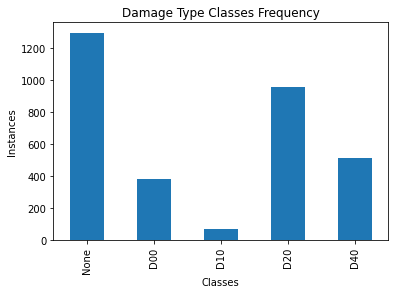

In [13]:
bar = test_df["class"].value_counts()
bar = bar.sort_index()
bar.plot(kind="bar")

plt.xticks((0, 1, 2, 3, 4), ("None", "D00", "D10", "D20", "D40"))
plt.xlabel("Classes")
plt.ylabel("Instances")
plt.title("Damage Type Classes Frequency")

# Preprocessing

In [14]:
# the number of total images and total labels.
def preprocessing():
    keys = []
    classes = []
    objects = []
    damages = []
    countries = []

    total_images = 0
    for gov in govs:

        total_images = total_images + 1
        path = base_path + gov + '/annotations/xmls/'
        files = os.listdir(path)
        for file in files:
            with open(os.path.join(path, file), 'r') as fp:
                data = fp.read()
                Bs_data = BeautifulSoup(data, "xml")
                img_name = Bs_data.find('filename').text
                cls_name = [i.get_text() for i in Bs_data.find_all('name')]
                obj_xmin = [i.get_text() for i in Bs_data.find_all('xmin')]
                obj_ymin = [i.get_text() for i in Bs_data.find_all('ymin')]
                obj_xmax = [i.get_text() for i in Bs_data.find_all('xmax')]
                obj_ymax = [i.get_text() for i in Bs_data.find_all('ymax')]
                keys.append(img_name)
                if(len(cls_name)!=0):
                    index=0
                    for i in cls_name:
                        keys.append(img_name)
                        classes.append(damageTypes.index(i))
                        damages.append(i)
                        objects.append("{xmin} {ymin} {xmax} {ymax}".format(xmin = obj_xmin[index], 
                                                                            ymin = obj_ymin[index],
                                                                            xmax = obj_xmax[index],
                                                                            ymax = obj_ymax[index]))
                        countries.append(img_name.split('_')[0])

                else:
                    keys.append(img_name)
                    classes.append(0)
                    damages.append('None')
                    objects.append("None")
                    countries.append(img_name.split('_')[0])
    
    frame = {'image': keys, 'class': classes, 'damage_type': damages, 'object': objects, 'country': countries}
    df = pd.DataFrame(frame)
    return df

train_df = dataframe_creation()
with pd.ExcelWriter('dataset/test_data.xlsx') as writer:  
    df.to_excel(writer, sheet_name='Sheet')      


In [15]:
train_df.head()

,image,class,damage_type,object,country
0,Czech_003090.jpg,0,None,None,Czech
1,Japan_001851.jpg,1,D00,37 422 151 590,Japan
2,Japan_007255.jpg,0,None,None,Japan
3,Japan_005918.jpg,0,None,None,Japan
4,Japan_004468.jpg,3,D20,427 436 594 587,Japan


Text(0.5, 1.0, 'Damage Type Classes Frequency')

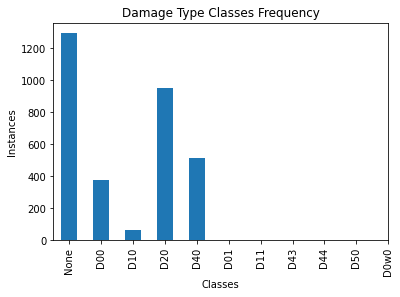

In [35]:
bar = train_df["class"].value_counts()
bar = bar.sort_index()
bar.plot(kind="bar")

plt.xticks([i for i in range(len(damageTypes))], damageTypes)
plt.xlabel("Classes")
plt.ylabel("Instances")
plt.title("Damage Type Classes Frequency")

# # Images converted into np.array

In [ ]:
def draw_images(image_file):
    gov = image_file.split('_')[0]
    img = cv2.imread(base_path + gov + '/JPEGImages/' + image_file.split('.')[0] + '.jpg')
    
    infile_xml = open(base_path + gov + '/Annotations/' +image_file)
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    
    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)

        font = cv2.FONT_HERSHEY_SIMPLEX

        # put text
        cv2.putText(img,cls_name,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)

        # draw bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0),3)
    return img

In [ ]:
for damageType in damageTypes:
    tmp = []
    for gov in govs:
        file = open(base_path + gov + '/ImageSets/Main/%s_trainval.txt' %damageType, 'r')

        for line in file:
            line = line.rstrip('\n').split('/')[-1]

            if line.split(' ')[2] == '1':
                tmp.append(line.split(' ')[0]+'.xml')
        
        
    random.shuffle(tmp)
    fig = plt.figure(figsize=(6,6))
    for number, image in enumerate(tmp[0:1]):
        img = draw_images(image)
        plt.subplot(1,1,number)
        plt.axis('off')
        plt.title('The image including ' + damageType)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
